In [1]:
import time
import pickle
import numpy as np
from scipy import signal
from scipy import fftpack
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import f06_postpro as f06
import dat_tools as dat
import utils
import rfp
import oma
import mac

### Funciones de transferencia nodales por simulación

In [2]:
# Diccionario de conexiones nodales
connect_dict_filename = 'connect_dict_subassembly.pickle'
with open(connect_dict_filename, 'rb') as handle:
    connect_dict = pickle.load(handle)

In [5]:
f06_sinsweep_filname = 'C:\RUNRUN\sate_subassembly_sinex.f06'
f06_modal_filname = r'C:\RUNRUN\modal_femap\sate_subassemblies_modalhm-000.f06'
dat_sinsweep_filname = 'C:\RUNRUN\sate_subassembly_sinex.dat'
freq, accel, nodes = f06.read_nodes_accel(f06_sinsweep_filname)
Xi = dat.read_damping(dat_sinsweep_filname)
coords = dat.read_node_coords(dat_sinsweep_filname, nodes)
mode_freqs_all, modes_theo_all = f06.read_modeshapes(f06_modal_filname, nodes)

0.04


Max value off diagonal: 0.144


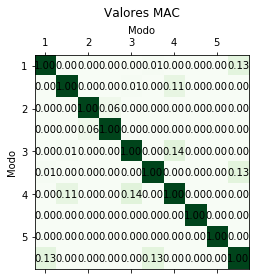

In [4]:
MAC_theo = mac.get_MAC_matrix(modes_theo_all.T[:,:15], modes_theo_all.T[:,:15])
mac.plot_MAC(MAC_theo, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_theo)))

In [5]:
# Transfer matrix
input_node = 1
input_node_str = str(input_node)

TF_dict = accel.copy()
# Delete input node
if input_node_str in TF_dict: del TF_dict[input_node_str]

total_nodes = len(TF_dict.keys())
dof_per_node = 3
total_dofs = total_nodes * dof_per_node
TF = np.zeros((len(freq), total_dofs), dtype=complex)
node_order = dict()
node_order['1'] = 0 # nodo origen
dof_order = dict()
col = 0
for node_str in TF_dict.keys():
    dof_order[node_str] = col
    node_order[node_str] = (col+3)//3 # dejo lugar para nodo del origen
    TF[:,col:col+3] = TF_dict[node_str]
    col += 3

In [6]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:total_dofs]

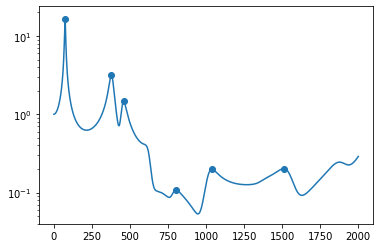

In [7]:
DOF = 51
mode_ind_TF = np.array([m for m in signal.argrelmax(np.abs(TF[:, DOF]), order=50)]).flatten()
plt.semilogy(freq, np.abs(TF[:, DOF]))
plt.scatter(freq[mode_ind_TF], np.abs(TF[mode_ind_TF, DOF]))

In [8]:
freq[mode_ind_TF]

array([  74.48425,  379.     ,  459.     ,  802.     , 1040.     ,
       1510.     ])

In [9]:
mode_freqs_all

array([ 74.48425, 106.9072 , 250.7339 , 287.9222 , 322.1733 , 380.6518 ,
       412.7897 , 422.8417 , 447.4774 , 454.6408 ])

In [10]:
freq_analysis_lim = 500
f_theo = freq[mode_ind_TF][freq[mode_ind_TF]<freq_analysis_lim]
total_modes = len(f_theo)
xi_theo = Xi*np.ones(total_modes)
mode_nums = np.arange(total_modes)+1

mask = [np.argmin(np.abs(mode_freqs_all - freq[mode_idx])) for mode_idx in mode_ind_TF]
mode_freqs = mode_freqs_all[mask]
modes_theo = modes_theo_all[mask,3:].T

Max value off diagonal: 1.000


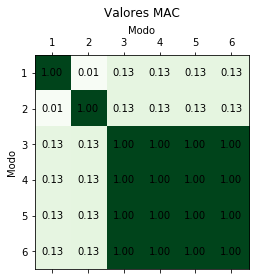

In [11]:
MAC_theo = mac.get_MAC_matrix(modes_theo, modes_theo)
mac.plot_MAC(MAC_theo, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_theo)))

Max value off diagonal: 0.519


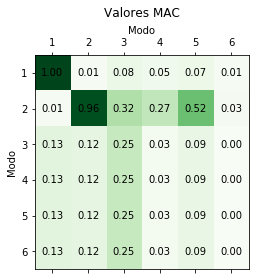

In [12]:
MAC_theo = mac.get_MAC_matrix(modes_theo, TF[mode_ind_TF, :].T)
mac.plot_MAC(MAC_theo, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_theo)))

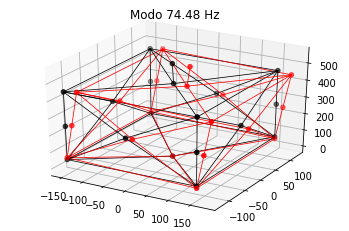

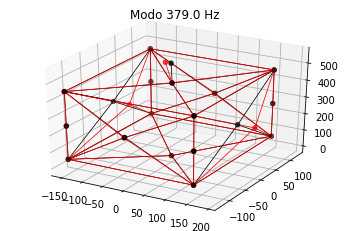

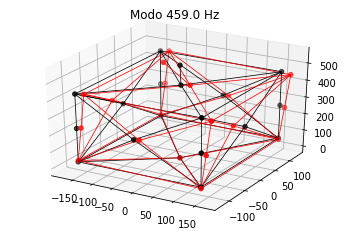

In [13]:
# for mode_idx in range(modes_theo.shape[1]):
for mode_idx in range(3):
    mode_shape = modes_theo[:, mode_idx]
    mode_name = 'Modo {} Hz'.format(np.round(freq[mode_ind_TF[mode_idx]], 2))
    utils.plot_3d_mode(node_order, coords, connect_dict, mode_shape, mode_name, magnif=40)

### Ruido blanco en la base

In [14]:
g_rms = 1
t_end = 120
f_s = 1200
delta_t = 1/f_s
t = np.linspace(0, t_end, int(t_end/delta_t))
Ug_time = g_rms * np.random.normal(size=len(t))

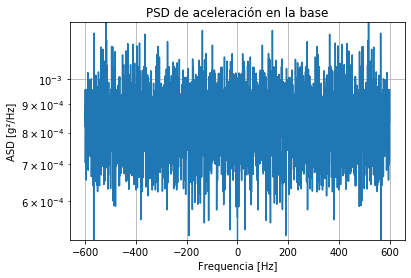

In [15]:
# PSD de aceleraciones en la base
nperseg = 4096
Ug_psd_freq, Ug_psd = signal.welch(Ug_time, 
                      fs=f_s, # sample rate
                      window='hamming', # apply a Hanning window before taking the DFT
                      nperseg=nperseg, # compute periodograms of 256-long segments of x
                      detrend='constant', # detrend x by subtracting the mean)
                      return_onesided=False)

plt.figure()
plt.semilogy(Ug_psd_freq, Ug_psd)
plt.title('PSD de aceleración en la base')
plt.ylim([np.min(Ug_psd[1:]), np.max(Ug_psd[1:])])
plt.xlabel('Frequencia [Hz]')
plt.ylabel('ASD [g²/Hz]')
plt.grid()
plt.show()

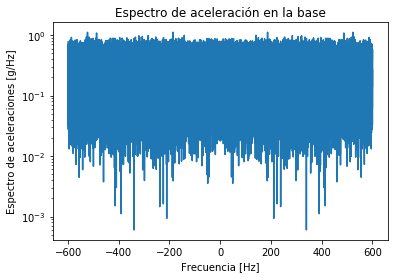

In [16]:
# Transformada de Fourier de aceleraciones en la base
Ug_fft_twosided = np.fft.fft(Ug_time) * delta_t
Ug_fft_freq_twosided = np.fft.fftfreq(len(t), d=delta_t)
# onesided_2kHz_size = len(Ug_fft_twosided)//4
# delta_t_2kHz = delta_t * 2
# Ug_fft_freq = Ug_fft_freq_twosided[:onesided_2kHz_size]
# Ug_fft = 2*Ug_fft_twosided[:onesided_2kHz_size]
Ug_fft = Ug_fft_twosided
Ug_fft_freq = Ug_fft_freq_twosided
plt.figure()
plt.semilogy(Ug_fft_freq, abs(Ug_fft))
plt.title('Espectro de aceleración en la base')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Espectro de aceleraciones [g/Hz]')
plt.show()

### Respuestas nodales

In [17]:
# Interpolacion de transferencias las frecuencias de excitación
TF_inter = np.zeros((len(Ug_fft_freq), TF.shape[1]), dtype=complex)
for dof in range(TF.shape[1]):
    TF_inter[:,dof] = np.interp(Ug_fft_freq, freq, TF[:,dof])

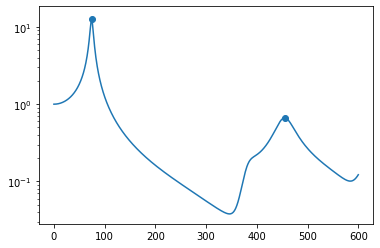

In [18]:
mode_ind_TFint = np.array([m for m in signal.argrelmax(np.abs(TF_inter[:, 21]), order=180)]).flatten()
plt.semilogy(Ug_fft_freq[:len(Ug_fft_freq)//2], np.abs(TF_inter[:len(Ug_fft_freq)//2,21]))
plt.scatter(Ug_fft_freq[mode_ind_TFint], np.abs(TF_inter[mode_ind_TFint,21]))

In [19]:
# Espectros de respuesta
ddotY_fft = (TF_inter.T*Ug_fft).T

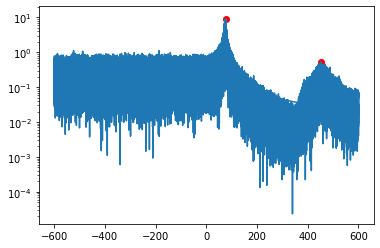

In [20]:
mode_ind_fft = np.array([m for m in signal.argrelmax(np.abs(ddotY_fft[:len(Ug_fft_freq)//2, 21]), order=4000)]).flatten()
plt.semilogy(Ug_fft_freq, np.abs(ddotY_fft[:,21]))
plt.scatter(Ug_fft_freq[mode_ind_fft], np.abs(ddotY_fft[mode_ind_fft,21]), color='r')

In [21]:
# Respuestas temporales
ddotY_time = fftpack.ifft(ddotY_fft, axis=0)

## GRFP

#### Estimador H1 de la FRF

In [22]:
S_xf = np.zeros((nperseg, total_dofs), dtype=complex)
for dof in range(total_dofs):
        f_Sxf, S_xf[:, dof] = signal.csd(ddotY_time[:, dof], Ug_time,
                                               fs=f_s,
                                               window='hanning',
                                               nperseg=nperseg,
                                               detrend='constant',
                                               axis=0,
                                               return_onesided=False)

In [23]:
f_H = f_Sxf[:len(f_Sxf)//2]
H1_premask = S_xf[:len(f_H),:]/Ug_psd[:len(f_H), np.newaxis]
# H1 = np.copy(H1_premask[:,mask[3:]])
H1 = H1_premask

In [24]:
DOF = 21
mode_ind_H1 = np.array([m for m in signal.argrelmax(np.abs(H1[:len(f_H), DOF]), order=400)]).flatten()

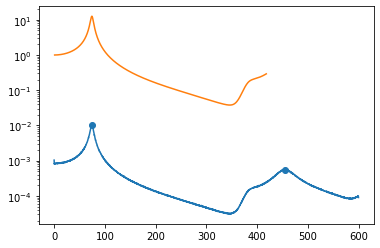

In [25]:
plt.semilogy(f_H[:len(f_H)], np.abs(H1[:len(f_H), DOF]))
plt.semilogy(freq[:len(f_H)//2], np.abs(accel['18'][:len(f_H)//2,0]))
plt.scatter(f_H[mode_ind_H1], np.abs(H1[mode_ind_H1, DOF]))

In [26]:
f_H[mode_ind_H1]

array([ 74.70703125, 454.1015625 ])

In [27]:
n_modes = 3
m = 2*n_modes-1
n = 2*n_modes
freq_range = [50, 500]
DOF = 21
idxes = np.where((f_H >= freq_range[0]) & (f_H <=freq_range[1]))[0]
modal_params, alpha = rfp.rfp(H1[idxes, DOF].T, 2*np.pi*f_H[idxes], n, m)
# modal_params2, alpha2 = rfp.rfp(accel['18'][50:len(freq)//8,0], 2*np.pi*freq[50:len(freq)//8], n, m)

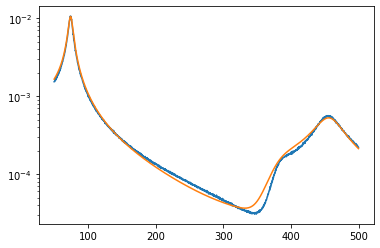

In [28]:
plt.semilogy(f_H[idxes], np.abs(H1[idxes, DOF]))
plt.semilogy(f_H[idxes], np.abs(alpha))
# plt.ylim([0.005, 0.05])
# plt.xlim([70, 80])
# plt.semilogy(freq[:len(f_H)//8], np.abs(accel['18'][:len(f_H)//8,0]))
# plt.semilogy(freq[50:len(freq)//8], np.abs(alpha2))

In [29]:
print(modal_params)
# print(modal_params2)

[array([ 74.58324508, 379.92884756, 456.9493086 ]), array([-0.0428147 , -0.073348  , -0.04495662]), array([197.3278073 , 145.14645161, 407.63542193]), array([ 0.0675364 ,  2.93912174, -0.0584567 ])]


In [30]:
DOFS = np.array([20, 21])
n_modes = 4
m = 2*n_modes-1
n = 2*n_modes
denom, denom_coeff = rfp.grfp_denominator(H1[idxes[:, np.newaxis], DOFS], 2*np.pi*f_H[idxes],n,m)

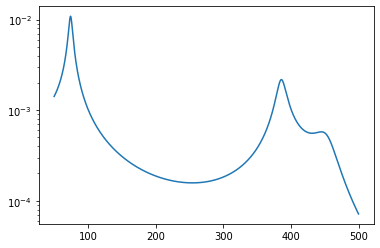

In [31]:
plt.semilogy(f_H[idxes], np.abs(1/denom))

In [32]:
[f_grfp, xi_grfp, modal_mag_n, modal_ang_n], alpha1 = rfp.grfp_parameters(H1[idxes,:], 2*np.pi*f_H[idxes], denom, denom_coeff, m)

In [33]:
print('Frecuencias modales:')
min_ind = np.min([len(vec) for vec in [mode_nums, f_theo, f_grfp]])
data = np.vstack((mode_nums[:min_ind], f_theo[:min_ind], f_grfp[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

Frecuencias modales:


,Modo,Teoría [Hz],GRFP [Hz]
0,1,74.48,74.46
1,2,379.00,385.72
2,3,459.00,453.31


In [34]:
print('Amortiguamientos modales:')
min_ind = np.min([len(vec) for vec in [mode_nums, xi_theo, xi_grfp]])
data = np.vstack((mode_nums[:min_ind], xi_theo[:min_ind], xi_grfp[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

Amortiguamientos modales:


,Modo,Teoría [Hz],GRFP [Hz]
0,1,0.04,-0.04
1,2,0.04,0.02
2,3,0.04,-0.04


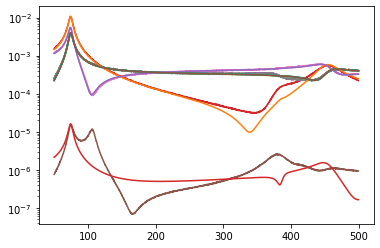

In [35]:
# DOFS = np.array([20,  21])
DOFS = np.array([5, 17, 20, 21, 23, 25, 33, 35])
plt.semilogy(f_H[idxes], np.abs(H1[idxes[:, np.newaxis], DOFS]))
plt.semilogy(f_H[idxes], np.abs(alpha1[:,DOFS]))
plt.show()

Max value off diagonal: 0.885


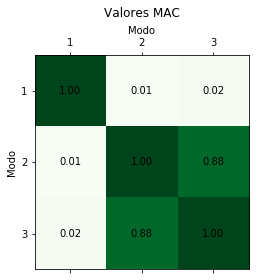

In [36]:
modes_grfp = (modal_mag_n*np.exp(1j*modal_ang_n)).T
MAC_grfp = mac.get_MAC_matrix(modes_grfp, modes_grfp)
mac.plot_MAC(MAC_grfp, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_grfp)))

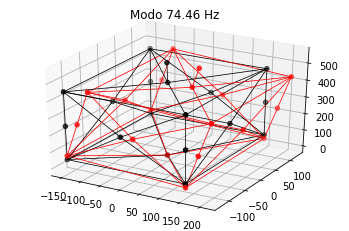

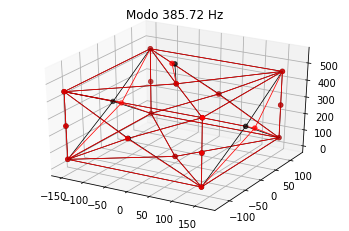

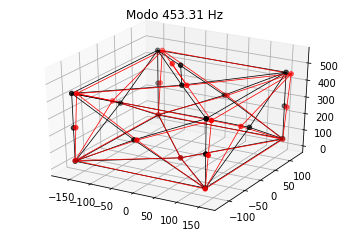

In [37]:
for mode_idx in range(modes_grfp.shape[1]):
    mode_shape = modes_grfp[:,mode_idx]
    mode_name = 'Modo {} Hz'.format(np.round(f_grfp[mode_idx], 2))
    utils.plot_3d_mode(node_order, coords, connect_dict, mode_shape, mode_name, magnif=80)

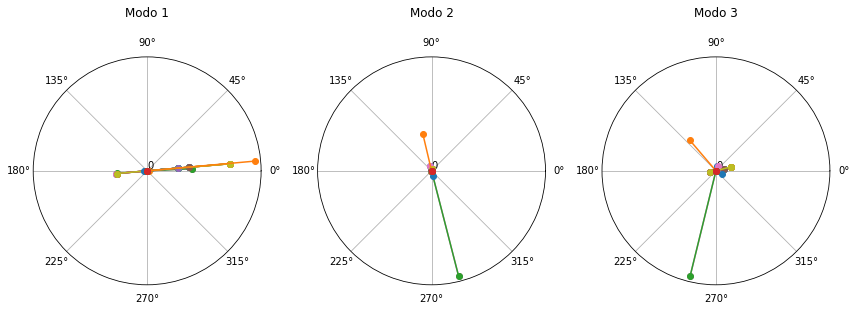

In [38]:
utils.plot_modes_complexity(modes_grfp)

Max value off diagonal: 0.886


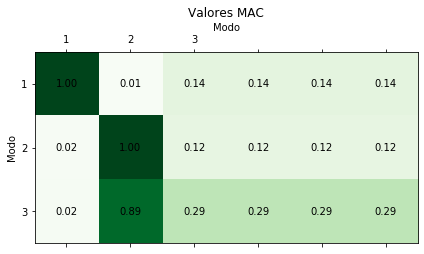

In [39]:
MAC_grfp = mac.get_MAC_matrix(modes_grfp, modes_theo)
mac.plot_MAC(MAC_grfp, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_grfp)))

## FDD

#### Matriz de densidades espectrales de la respuesta

In [40]:
S_xx = np.zeros((nperseg, total_dofs, total_dofs), dtype=complex)

start = time.time()
for dof1 in range(total_dofs):
    for dof2 in range(total_dofs):
        f_S, S_xx[:, dof1, dof2] = signal.csd(ddotY_time[:, dof1], ddotY_time[:, dof2],
                                                               fs=f_s,
                                                               window='hanning',
                                                               nperseg=nperseg,
                                                               detrend='constant',
                                                               axis=0,
                                                               return_onesided=False)
end = time.time()
print('Tiempo de calculo de S_xx: {}s'.format(round(end - start,2)))

Tiempo de calculo de S_xx: 64.22s


In [41]:
# Extraigo frecuencias y formas de modo por SVD
u_fdd, s_fdd, vh_fdd = np.linalg.svd(S_xx)

freq_fdd = f_S[:len(f_S)//2]
# Maximos del primer valor singular
mode_ind_fdd = np.array([m for m in signal.argrelmax(s_fdd[:len(f_S)//2, 0], order=300)]).flatten()
mode_ind_fdd2 = np.array([m for m in signal.argrelmax(s_fdd[:len(f_S)//2, 1], order=150)]).flatten()

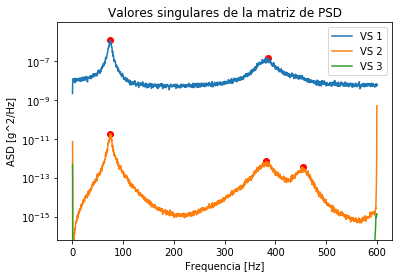

In [42]:
plt.semilogy(freq_fdd, s_fdd[:len(freq_fdd), :3])
plt.ylim([np.min(s_fdd[10:len(freq_fdd), 1]), None])
plt.scatter(freq_fdd[mode_ind_fdd],
            abs(s_fdd[mode_ind_fdd, 0]),
            color='r')
plt.scatter(freq_fdd[mode_ind_fdd2],
            abs(s_fdd[mode_ind_fdd2, 1]),
            color='r')
plt.title('Valores singulares de la matriz de PSD')
plt.ylabel('ASD [g^2/Hz]')
plt.xlabel('Frequencia [Hz]')
lgnd  = ['VS {}'.format(col+1) for col in range(3)]
plt.legend(lgnd, loc='upper right')
plt.show()

In [43]:
f_fdd = freq_fdd[mode_ind_fdd2]
fdd_total_modes = len(f_fdd)
min_ind = np.min([len(vec) for vec in [mode_nums, f_theo, f_grfp, f_fdd]])
data = np.vstack((mode_nums[:min_ind], f_theo[:min_ind], f_grfp[:min_ind], f_fdd[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]', 'FDD [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

,Modo,Teoría [Hz],GRFP [Hz],FDD [Hz]
0,1,74.48,74.46,74.71
1,2,379.00,385.72,382.03
2,3,459.00,453.31,453.22


IndexError: index 2 is out of bounds for axis 0 with size 2

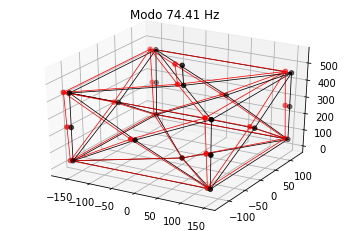

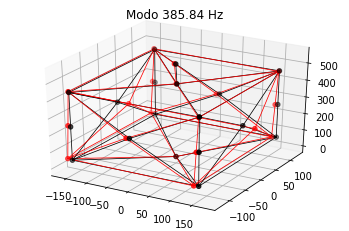

In [44]:
for mode_idx in range(fdd_total_modes):
    mode_shape = u_fdd[mode_ind_fdd[mode_idx], :, 0]
    mode_name = 'Modo {} Hz'.format(np.round(freq_fdd[mode_ind_fdd[mode_idx]], 2))
    utils.plot_3d_mode(node_order, coords, connect_dict, mode_shape, mode_name, magnif=100)

In [ ]:
modes_fdd = u_fdd[mode_ind_fdd[:fdd_total_modes],:,0].T
MAC_fdd = mac.get_MAC_matrix(modes_fdd, modes_theo)
mac.plot_MAC(MAC_fdd, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_fdd)))

In [ ]:
mac.get_MAC(u_fdd[mode_ind_fdd2[2],:,1].T, modes_theo[:,2])

In [ ]:
freq_fdd[mode_ind_fdd2]

### EFDD

In [ ]:
sv_num = 1
mac_th = 0.85
sdof_psd = np.zeros((f_S.size, fdd_total_modes), dtype=complex)
sdof_acf = np.zeros((f_S.size, fdd_total_modes), dtype=complex)
t_sdof_acf = np.linspace(0, sdof_psd.shape[0]*delta_t, sdof_psd.shape[0])
f_efdd = np.zeros(fdd_total_modes)
xi_efdd = np.zeros(fdd_total_modes)
R2 = np.zeros(fdd_total_modes)
for mode in range(fdd_total_modes):
    peak_idx = mode_ind_fdd2[mode]
    idx_low, idx_high = oma.get_efdd_segment(u_fdd, peak_idx, mac_th, sv_num)
    sdof_psd[idx_low:idx_high, mode] = s_fdd[idx_low:idx_high, 1]
    sdof_acf[:, mode] = fftpack.ifft(sdof_psd[:, mode])
    # Find index where amplitude stops falling
    decay_end = np.where(np.diff(np.abs(sdof_acf[:, mode]))>0)[0][0] 
    decay = np.real(sdof_acf[:decay_end, mode])
    plt.plot(decay)
    xi_efdd[mode], R2[mode], A, b, c, m = oma.get_damp_from_decay(decay)
    f_efdd_damped = oma.get_freq_from_signal(t_sdof_acf, sdof_acf[:, mode])
    f_efdd[mode] = f_efdd_damped / np.sqrt(1-xi_efdd[mode]**2)
    peak_nums = np.linspace(1, A.shape[0], A.shape[0])

In [ ]:
print('Frecuencias modales:')
min_ind = np.min([len(vec) for vec in [mode_nums, f_theo, f_grfp, f_fdd, f_efdd]])
data = np.vstack((mode_nums[:min_ind], f_theo[:min_ind], f_grfp[:min_ind], f_fdd[:min_ind], f_efdd[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]', 'FDD [Hz]', 'EFDD [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

In [ ]:
min_ind = np.min([len(vec) for vec in [mode_nums, xi_theo, xi_grfp, xi_efdd]])
data = np.vstack((mode_nums[:min_ind], xi_theo[:min_ind], xi_grfp[:min_ind], xi_efdd[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]', 'EFDD [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

In [ ]:
modes_efdd = np.zeros((u_fdd.shape[1], fdd_total_modes), dtype=complex)
for mode in range(fdd_total_modes):
    peak_idx = mode_ind_fdd[mode]
    seg_idxes = oma.get_efdd_segment(u_fdd, peak_idx, mac_th)
    modes_efdd[:, mode] = oma.get_mean_modeshape_efdd(segment_idxes=seg_idxes,
                                                      peak_idx=peak_idx,
                                                      s_vectors=u_fdd)

# Normalización
for col in range(modes_efdd.shape[1]):
    modes_efdd[:,col] = modes_efdd[:,col]/max(abs(modes_efdd[:,col]))

In [ ]:
MAC_efdd = mac.get_MAC_matrix(modes_efdd, modes_theo)
mac.plot_MAC(MAC_efdd, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_efdd)))

### CFDD

In [ ]:
sv_num = 0
mac_th = 0.8
f_cfdd = np.zeros(fdd_total_modes)
xi_cfdd = np.zeros(fdd_total_modes)

freq_hat = np.linspace(0, f_S[len(f_S)//2-1], 4000)
psd_hat = np.zeros((freq_hat.size, fdd_total_modes))

for mode in range(fdd_total_modes):
    peak_idx = mode_ind_fdd[mode]
    efdd_idxes = oma.get_efdd_segment(u_fdd, peak_idx, mac_th, sv_num)
    f_cfdd[mode], xi_cfdd[mode], psd_hat[:, mode] = oma.curve_fit_psd_peak(f_S[:len(f_S)//2], s_fdd[:len(f_S)//2, 0], efdd_idxes, freq_hat)
    
    plt.semilogy(f_S[efdd_idxes[0]:efdd_idxes[1]],
                 abs(s_fdd[efdd_idxes[0]:efdd_idxes[1], 0]),
                 color=colors[mode])
    plt.semilogy(freq_hat[:freq_hat.size//2],
                 abs(psd_hat[:freq_hat.size//2, mode]),
                 color=colors[mode],
                 linestyle='--')

plt.title('Ajuste por CFDD de picos de PSD')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('PSD [g^2/Hz]')
plt.show()
# plt.ylim([np.min(s_fdd[:, 0]), None])

In [ ]:
print('Frecuencias modales:')
min_ind = np.min([len(vec) for vec in [mode_nums, f_theo, f_grfp, f_fdd, f_efdd, f_cfdd]])
data = np.vstack((mode_nums[:min_ind], f_theo[:min_ind], f_grfp[:min_ind], f_fdd[:min_ind], f_efdd[:min_ind], f_cfdd[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]', 'FDD [Hz]', 'EFDD [Hz]', 'CFDD [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

In [ ]:
min_ind = np.min([len(vec) for vec in [mode_nums, xi_theo, xi_grfp, xi_efdd, xi_cfdd]])
data = np.vstack((mode_nums[:min_ind], xi_theo[:min_ind], xi_grfp[:min_ind], xi_efdd[:min_ind], xi_cfdd[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]', 'EFDD [Hz]', 'CFDD [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=3)